In [1]:
import os
import torch
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from helpers import get_files_in_dir
from torchvision.io import read_image




In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 5, 33, 33])
torch.Size([5445])
torch.Size([1, 5, 11, 11])
torch.Size([605])


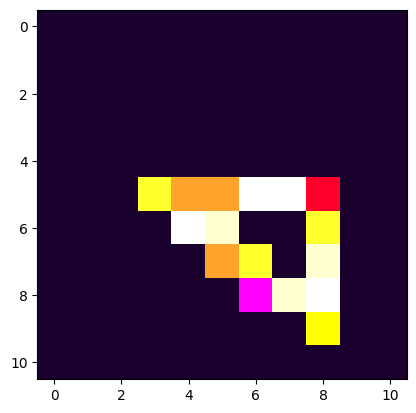

In [3]:
# to 10x10x10
# nn.Conv2d(3, 10, 10, stride=10, padding=0)

# to 10x9x9
# nn.Conv2d(3, 10, 15, stride=10, padding=0)
from helpers import draw_random_triangle
triangle = draw_random_triangle(100,(1,5))
# from 3x100x100 to 3x20x20
c1 = nn.Conv2d(3, 5, 3, stride=3, padding=0)
#c1 = nn.Conv2d(3, 10, 10, stride=10, padding=0)
#c1 = nn.Conv2d(3, 10, 15, stride=10, padding=0)
m1 = nn.MaxPool2d(2, stride=3)



triangle_tensor = torch.tensor(triangle).permute(2, 0, 1).unsqueeze(0).float()
triangle_tensor = c1(triangle_tensor)

print(triangle_tensor.shape)
print(triangle_tensor.flatten().shape)

triangle_tensor = m1(triangle_tensor)
print(triangle_tensor.shape)
print(triangle_tensor.flatten().shape)


# visualize
triangle_tensor = triangle_tensor.squeeze(0)[0:3]
triangle_tensor = triangle_tensor.permute(1, 2, 0)
plt.imshow(triangle_tensor.detach().numpy())


In [18]:
class tit(nn.Module):
    def __init__(self):
        super().__init__()
        
        # to 10x10x10
        # nn.Conv2d(3, 10, 10, stride=10, padding=0)

        # to 10x9x9
        # nn.Conv2d(3, 10, 15, stride=10, padding=0)
        
        
        self.c1 = nn.Conv2d(3, 5, 3, stride=3, padding=0)
        self.c2 = nn.Conv2d(3, 10, 10, stride=10, padding=0)
        self.c3 = nn.Conv2d(3, 10, 15, stride=10, padding=0)
        
        self.m1 = nn.MaxPool2d(2, stride=3)
        self.m2 = nn.MaxPool2d(2, stride=2)
        self.m3 = nn.MaxPool2d(2, stride=2)
        
        self.n1 = nn.LayerNorm(605)
        self.n2 = nn.LayerNorm(250)
        self.n3 = nn.LayerNorm(160)
        
        self.l1  = nn.Linear(605, 200, bias=True)
        self.l2  = nn.Linear(250,150, bias=True)
        self.l3  = nn.Linear(160,100, bias=True)
        
        self.n_combine = nn.LayerNorm(200+150+100)
        self.l_combine = nn.Linear(200+150+100,800, bias=True)
        
        self.l_combine2 = nn.Linear(800,5, bias=True)
        
        self.re1 = nn.ReLU()
        self.re2 = nn.ReLU()
        self.re3 = nn.ReLU()
        self.re4 = nn.ReLU()
        self.re5 = nn.ReLU()
        self.re6 = nn.ReLU()
        self.re7 = nn.ReLU()
          
        


        #self.linear_relu_stack = nn.Sequential(
        #    nn.Linear(5, 5, bias=True),
            #nn.Linear(5, 5, bias=True),
            #nn.ReLU(),
            #nn.ReLU()
        #)

    def forward(self, x):
        x1 = self.c1(x) 
        x1 = self.re1(x1)
        x1 = self.m1(x1)       
        x1 = torch.flatten(x1,1)
        #x1 = self.n1(x1)
        x1 = self.l1(x1)
        x1 = self.re2(x1)
        
        x2 = self.c2(x)
        x2 = self.re3(x2)
        x2 = self.m2(x2)
        x2 = torch.flatten(x2,1)
        #x2 = self.n2(x2)
        x2 = self.l2(x2)
        x2 = self.re4(x2)
        
        x3 = self.c3(x)
        x3 = self.re5(x3)
        x3 = self.m3(x3)
        x3 = torch.flatten(x3,1)
        #x3 = self.n3(x3)
        x3 = self.l3(x3)
        x3 = self.re6(x3)
        
        x = torch.cat((x1,x2,x3),1)
        #x = self.n_combine(x)
        x = self.l_combine(x)
        x = self.re7(x)
        x = self.l_combine2(x)
        #x = self.re7(x)
        
        
        return x

In [22]:
from figures_dataset import FiguresData
train_dataset = FiguresData(100,3000, augment=True)
print("Training ponits: ",len(train_dataset))

valid_dataset = FiguresData(100,150)
print("Validation ponits: ",len(valid_dataset))


Training ponits:  3000
Validation ponits:  150


tensor(2)


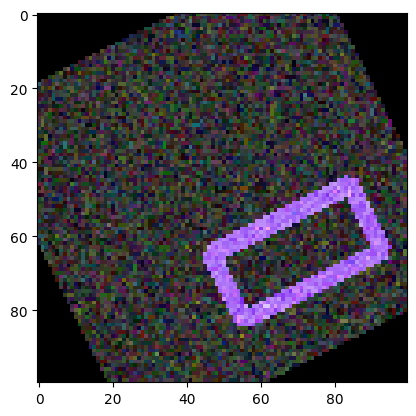

tensor(3)


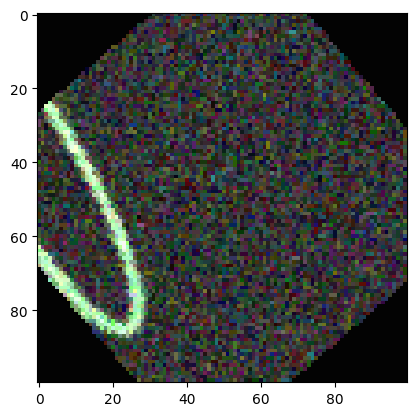

tensor(2)


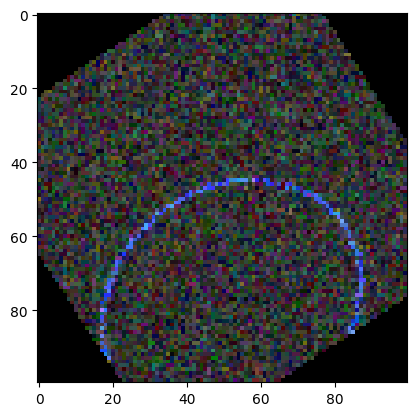

tensor(1)


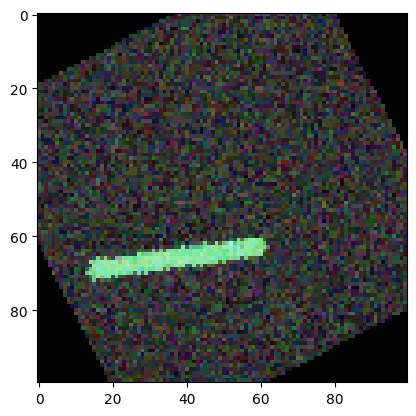

tensor(2)


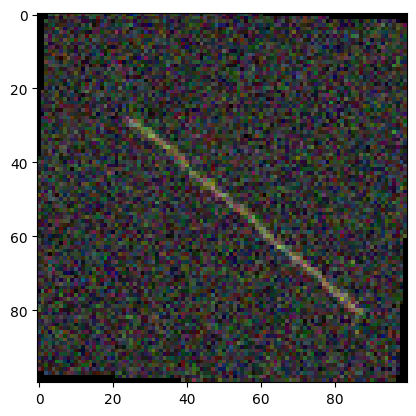

In [6]:
#terate training_set and visualize 
for i in range(5):
    print(train_dataset[i][1])
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.show()

In [7]:
# TRAINING IMPORTS
from torch import nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torcheval.metrics.functional import multiclass_accuracy
from torch.nn import CrossEntropyLoss

In [26]:
# TRAINING LOOP
model = tit()
model = model.to(device)
train_loader = DataLoader(train_dataset, batch_size=32)#, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)#, shuffle=True)

In [27]:

ps = 0
for name, param in model.named_parameters():
    #print(f"Layer: {name} | Size: {param.size()} \n")
    param.requires_grad_ = True
    ps += param.numel()
    

epochs = 24

optimizer = optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5) #learning rate decay
criterion = CrossEntropyLoss()
iter_num = 0

lowest_loss = 999
valid_loss = 900
best_epoch = 0

epoch_pbar = tqdm(range(epochs))

print("Params to train: ",ps)

for epoch in epoch_pbar:
    print('Epoch num {}'.format(epoch))
    model.train()
    train_loss = 0

    #batch_pbar = enumerate(tqdm(train_loader))
    #for i,batch in batch_pbar:
    for i, batch in zip(range(len(train_loader)),train_loader):
        images, labels = batch
        images = images.to(torch.float32)
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)

        loss =  criterion(pred,labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item()
        iter_num+=1

    train_loss /= (i+1)

    if (epoch == 0) or (epoch > 4 and epoch % 5 == 0):
        model.eval()
        valid_loss = 0
        valid_accuracy = 0
        with torch.no_grad():
            for i, batch in zip(range(len(valid_loader)),valid_loader):
                images, labels = batch
                images = images.to(torch.float32)
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images)

                loss =  criterion(pred,labels)
                valid_loss += loss.item()
                valid_accuracy += multiclass_accuracy(pred, labels)

        valid_loss /= (i+1)
        valid_accuracy /= (i+1)

            
        print('Validation loss {} | Validation accuracy {}'.format(round(valid_loss, 4), round(valid_accuracy.item(), 4)))

    print('Epoch num {}| train loss {} | lr_opt {} \n'.format(epoch,round(train_loss, 4),optimizer.param_groups[0]['lr']))

    if(epoch == 0):
        lowest_loss = valid_loss
    

    if (valid_loss + 0.01) < lowest_loss:
        lowest_loss = valid_loss
        best_epoch = epoch
        #print('New lowest loss: {} at epoch {}'.format(round(lowest_loss, 4), best_epoch))
    
    elif epoch>15 and epoch - best_epoch > 8:
        print('Early stopping at epoch {}. Best epoch: {} with score {} '.format(epoch, best_epoch, lowest_loss))
        break 

    
    scheduler.step()



  0%|          | 0/24 [00:00<?, ?it/s]

Params to train:  552595
Epoch num 0
Validation loss 1.6068 | Validation accuracy 0.2665
Epoch num 0| train loss 1.4449 | lr_opt 0.01 

Epoch num 1
Epoch num 1| train loss 1.3963 | lr_opt 0.01 

Epoch num 2
Epoch num 2| train loss 1.3925 | lr_opt 0.01 

Epoch num 3
Epoch num 3| train loss 1.3883 | lr_opt 0.005 

Epoch num 4
Epoch num 4| train loss 1.3896 | lr_opt 0.005 

Epoch num 5
Validation loss 1.3977 | Validation accuracy 0.2142
Epoch num 5| train loss 1.3903 | lr_opt 0.005 

Epoch num 6
Epoch num 6| train loss 1.3892 | lr_opt 0.0025 

Epoch num 7
Epoch num 7| train loss 1.3889 | lr_opt 0.0025 

Epoch num 8
Epoch num 8| train loss 1.3879 | lr_opt 0.0025 

Epoch num 9
Epoch num 9| train loss 1.3876 | lr_opt 0.00125 

Epoch num 10
Validation loss 1.3852 | Validation accuracy 0.2915
Epoch num 10| train loss 1.3875 | lr_opt 0.00125 

Epoch num 11
Epoch num 11| train loss 1.3869 | lr_opt 0.00125 

Epoch num 12
Epoch num 12| train loss 1.3874 | lr_opt 0.000625 

Epoch num 13
Epoch num 1

KeyboardInterrupt: 

In [15]:
model.eval()
model.cpu()
del(model)

In [ ]:
crit = nn.CrossEntropyLoss()
dummy_pred = [0,0,0,0,0]
dummy_abel = 4
dummy_pred = torch.tensor(dummy_pred).float()
dummy_abel = torch.tensor(dummy_abel)
crit(dummy_pred,dummy_abel)

tensor(1.6094)

RuntimeError: Given normalized_shape=[605], expected input with shape [*, 605], but got input of size[5, 121]

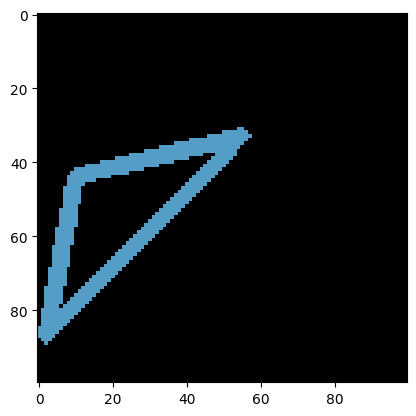

In [20]:
# make random triangle
from helpers import draw_random_triangle
crit = nn.CrossEntropyLoss()
model.cpu()
triangle1 = draw_random_triangle(100,(1,5))
# visualize triangle
plt.imshow(triangle)
# use model to predict triangle
triangle_tensor1 = torch.tensor(triangle1).permute(2, 0, 1).float()
# triangle2 = draw_random_triangle(100,(1,5))
# triangle_tensor2 = torch.tensor(triangle1).permute(2, 0, 1).float()

# # make mini-batch of triangles
# batch = torch.stack([triangle_tensor1,triangle_tensor2])
with torch.no_grad():    
    pred = model(triangle_tensor1)
    

print(pred)
# calculate loss
target = torch.tensor([4])
loss = crit(pred, target)
print(loss)

